<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [3]:
import os

!git clone https://github.com/tomhyhan/{repo_name}.git

if os.getcwd() != f"/content/{repo_name}":
    %cd {repo_name}
!git pull
!pwd


Cloning into 'noodles'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 305 (delta 29), reused 26 (delta 11), pack-reused 244 (from 1)
Receiving objects: 100% (305/305), 3.43 MiB | 8.03 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/noodles
Already up to date.
/content/noodles


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [6]:

from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [7]:

!pip install torchinfo
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.4 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed, save_model
from model.data import CLASS_ENCODER, create_csv, CLASS_DECODER
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [10]:
reset_seed(SEED)

In [11]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [12]:

data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

In [ ]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['regnet', 'convnext']

# N=100
# perm_indices = np.random.permutation(N)
# X = X[perm_indices]
# y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        train_data_accuracy = PastaData(train_set, train_label_set, transform_list=test_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        train_loader_accuracy = DataLoader(train_data_accuracy, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
        os.makedirs(result_dir, exist_ok=True)

        out_file = os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt")

        resume = False
        if os.path.exists(out_file):
            print(f"=== {out_file} exist! ===")
            resume = True

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, model, optimizer, scaler, end_epoch = trainer(
            model,
            train_loader,
            train_loader_accuracy,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            model_config=model_config,
            device=device,
            resume=resume,
            out_file=out_file,
            num_classes=num_classes
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        save_model(model, optimizer, scaler, end_epoch, out_file, best_accuracy)
        # torch.save(best_params, os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)

    print("current_model_accuracies", current_model_accuracies)


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


5032 1259
=== ../drive/My Drive/noodles/./regnet/regnet_k_fold_0.pt exist! ===
Resume Training from previous check point


/content/noodles/model/utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out_file, map_location="cpu")


Epoch 16/20:   0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from pathlib import Path
import glob

In [ ]:
models = ['regnet', 'convnext']
for model_name in models:
    model_config = config_manager.config[model_name]
    result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
    output_dir = Path(result_dir)
    checkpt_paths =  glob.glob(os.path.join(output_dir, f"{model_name}_k_fold_*.pt"))
    accuracy_list = []
    epochs = []
    for checkpt_path in checkpt_paths:
        checkpoint = torch.load(checkpt_path, map_location='cpu')
        accuracy_list.append(checkpoint["best_accuracy"])
        epochs.append(checkpoint["epoch"] + 1)
    print("Model: ", model_name)
    print("epochs: ", epochs)
    print("Accuracy list: ",  accuracy_list)
    print("Accuracy Mean: ", np.mean(accuracy_list))
    print("Accuracy std: ", np.std(accuracy_list))

<ipython-input-24-26b7d8bcf7a5>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpt_path, map_location='cpu')


Model:  regnet
epochs:  [15, 15, 15, 15, 15]
Accuracy list:  [0.8733333333333333, 0.8816666666666667, 0.875, 0.8633333333333333, 0.8708333333333333]
Accuracy Mean:  0.8728333333333333
Accuracy std:  0.00595352369983061
Model:  convnext
epochs:  [15, 15, 15, 15, 15]
Accuracy list:  [0.8621848739495799, 0.8747899159663866, 0.8831932773109243, 0.8680672268907563, 0.873109243697479]
Accuracy Mean:  0.8722689075630253
Accuracy std:  0.0070106398704585324


6291 699


Downloading: "https://download.pytorch.org/models/regnet_y_32gf_swag-04fdfa75.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf_swag-04fdfa75.pth
100%|██████████| 554M/554M [00:02<00:00, 213MB/s]


Epoch 1/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [1.0441935388761256e-05]
Epoch 1 Loss: 2.6018261966553142 Train Accuracy: 0             Validation Accuracy: 0.67
Global gradient norm: 16.2190691794352


Epoch 2/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [2.803863607367106e-05]
Epoch 2 Loss: 1.8365688923191517 Train Accuracy: 0             Validation Accuracy: 0.84
Global gradient norm: 10.792034405347165


Epoch 3/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [5.206690168524778e-05]
Epoch 3 Loss: 1.5758927480337468 Train Accuracy: 0             Validation Accuracy: 0.875
Global gradient norm: 7.499511615436781


Epoch 4/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [7.607720994958426e-05]
Epoch 4 Loss: 1.5088919521646296 Train Accuracy: 0             Validation Accuracy: 0.88
Global gradient norm: 8.550604769296568


Epoch 5/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [9.36248585957182e-05]
Epoch 5 Loss: 1.4575904046601438 Train Accuracy: 0             Validation Accuracy: 0.855
Global gradient norm: 10.848228242975386


Epoch 6/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [9.999996438227345e-05]
Epoch 6 Loss: 1.334082696032017 Train Accuracy: 0             Validation Accuracy: 0.8733333333333333
Global gradient norm: 5.768020032279652


Epoch 7/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [9.873308574740407e-05]
Epoch 7 Loss: 1.2934127491205296 Train Accuracy: 0             Validation Accuracy: 0.8583333333333333
Global gradient norm: 4.891810834890028


Epoch 8/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [9.502253673035055e-05]
Epoch 8 Loss: 1.2689585432093193 Train Accuracy: 0             Validation Accuracy: 0.865
Global gradient norm: 5.6264163391336615


Epoch 9/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [8.90543797527313e-05]
Epoch 9 Loss: 1.2365476860010878 Train Accuracy: 0             Validation Accuracy: 0.8816666666666667
Global gradient norm: 3.796263827124854


Epoch 10/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [8.112788312625742e-05]
Epoch 10 Loss: 1.1790091300264318 Train Accuracy: 0             Validation Accuracy: 0.88
Global gradient norm: 3.280508747697665


Epoch 11/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [7.164051448994774e-05]
Epoch 11 Loss: 1.1752827814284792 Train Accuracy: 0             Validation Accuracy: 0.885
Global gradient norm: 2.4970861491582577


Epoch 12/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [6.106801012302822e-05]
Epoch 12 Loss: 1.162921962268809 Train Accuracy: 0             Validation Accuracy: 0.88
Global gradient norm: 3.967505680636359


Epoch 13/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [4.994051954138977e-05]
Epoch 13 Loss: 1.1514448314271075 Train Accuracy: 0             Validation Accuracy: 0.8766666666666667
Global gradient norm: 2.986638816048983


Epoch 14/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [3.8816021587149923e-05]
Epoch 14 Loss: 1.0974261158324303 Train Accuracy: 0             Validation Accuracy: 0.8916666666666667
Global gradient norm: 2.08871910908144


Epoch 15/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [2.8252345039592346e-05]
Epoch 15 Loss: 1.0808353807697906 Train Accuracy: 0             Validation Accuracy: 0.8933333333333333
Global gradient norm: 2.169609485571162


Epoch 16/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [1.8779196750883348e-05]
Epoch 16 Loss: 1.0926106721162796 Train Accuracy: 0             Validation Accuracy: 0.895
Global gradient norm: 1.4423669551497316


Epoch 17/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [1.0871599932641219e-05]
Epoch 17 Loss: 1.085268423912373 Train Accuracy: 0             Validation Accuracy: 0.8983333333333333
Global gradient norm: 2.0120222228670306


Epoch 18/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [4.926074508581344e-06]
Epoch 18 Loss: 1.0601844451528915 Train Accuracy: 0             Validation Accuracy: 0.8983333333333333
Global gradient norm: 1.7818578927648865


Epoch 19/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [1.2407539498181523e-06]
Epoch 19 Loss: 1.0658459932880198 Train Accuracy: 0             Validation Accuracy: 0.9
Global gradient norm: 2.298336907682435


Epoch 20/20:   0%|          | 0/188 [00:00<?, ?it/s]

Learning Rate: [4.3561772655491803e-10]
Epoch 20 Loss: 1.0584716562260972 Train Accuracy: 0             Validation Accuracy: 0.9
Global gradient norm: 1.7377594366095122
End of Training for regnet Model 7-fold
best accuracy: 0.9


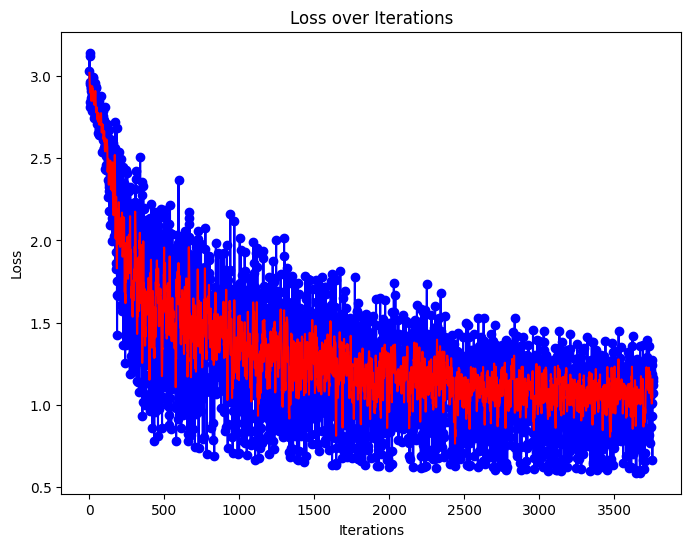

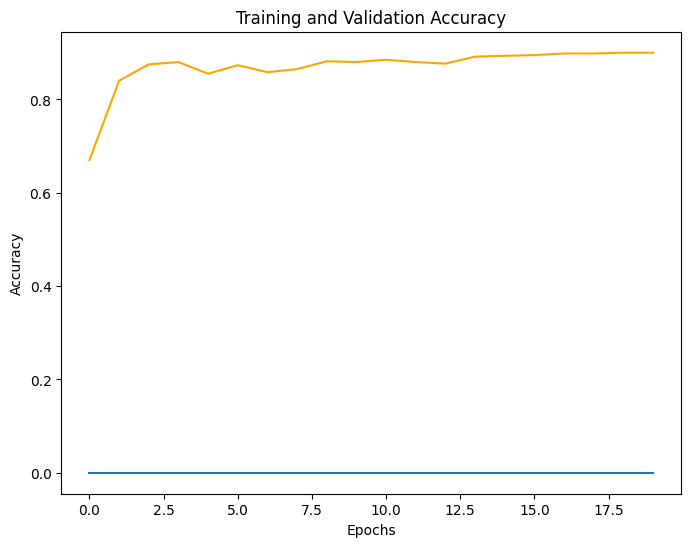

In [14]:
# final model training
# X, test_data, y, test_label
train_set = X
train_label_set = y

val_set = test_data
val_label_set = test_label
print(len(X), len(test_data))
model_name = "regnet"

model_config = config_manager.config[model_name]
lr = config_manager.config.lr
num_epochs = config_manager.config.num_epochs
num_classes = config_manager.config.num_classes
k_id = 7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_transform = create_train_transforms()
test_transform = create_test_transforms()

train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
train_data_accuracy = PastaData(train_set, train_label_set, transform_list=test_transform)
val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

train_loader = DataLoader(train_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
train_loader_accuracy = DataLoader(train_data_accuracy, batch_size=model_config.batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=model_config.batch_size, shuffle=False, drop_last=True)

model = create_model(model_name, num_classes)
model.to(device)

result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
os.makedirs(result_dir, exist_ok=True)

out_file = os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt")

resume = False
if os.path.exists(out_file):
    print(f"=== {out_file} exist! ===")
    resume = True

#  need to make dataframe from images
loss_history, train_accuracy_history, \
val_accuracy_history, best_accuracy, model, optimizer, scaler, end_epoch = trainer(
    model,
    train_loader,
    train_loader_accuracy,
    val_loader,
    num_epochs=num_epochs,
    lr=lr,
    model_config=model_config,
    device=device,
    resume=resume,
    out_file=out_file,
    num_classes=num_classes,
    eval_mode=True
)


print(f"End of Training for {model_name} Model {k_id}-fold")
print(f"best accuracy: {best_accuracy}")

save_model(model, optimizer, scaler, end_epoch, out_file, best_accuracy)
# torch.save(best_params, os.path.join(result_dir, f"{model_name}_k_fold_{k_id}.pt"))
draw_loss(loss_history)
draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)


In [ ]:
# Inference

In [42]:
# test_data, test_label

model_name = "regnet"
model_config = config_manager.config[model_name]
result_dir = os.path.join(GOOGLE_DRIVE_PATH, model_config.output_dir)
os.makedirs(result_dir, exist_ok=True)
num_classes = config_manager.config.num_classes
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_file = os.path.join(result_dir, f"{model_name}_k_fold_7.pt")
checkpoint = torch.load(out_file, map_location="cpu")
print(checkpoint["best_accuracy"])
print(num_classes)



<ipython-input-42-314fb1fb423a>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out_file, map_location="cpu")


0.9
16


In [43]:
import cv2
import matplotlib.pyplot as plt
from model.data import CLASS_DECODER

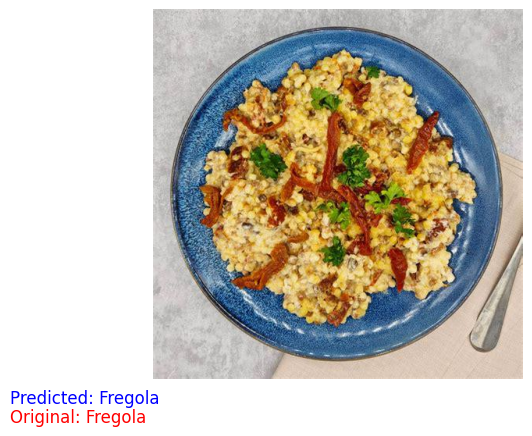

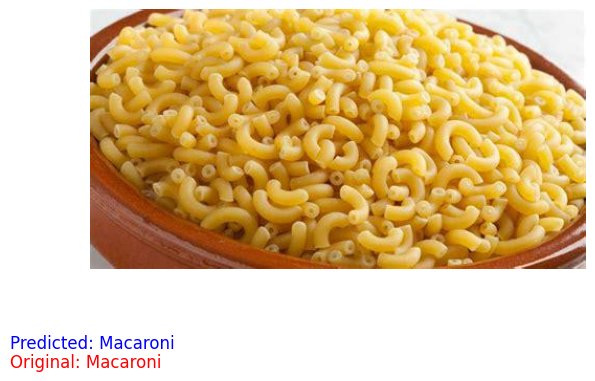

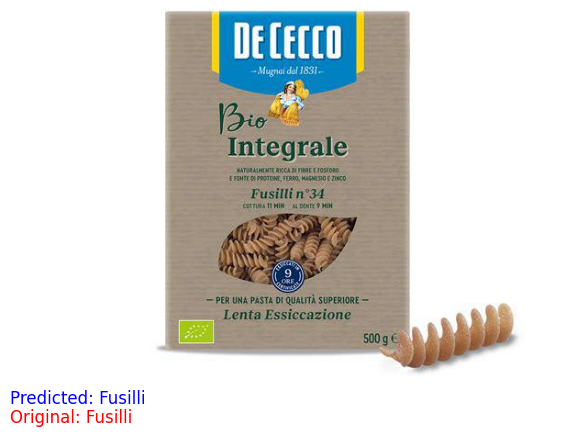

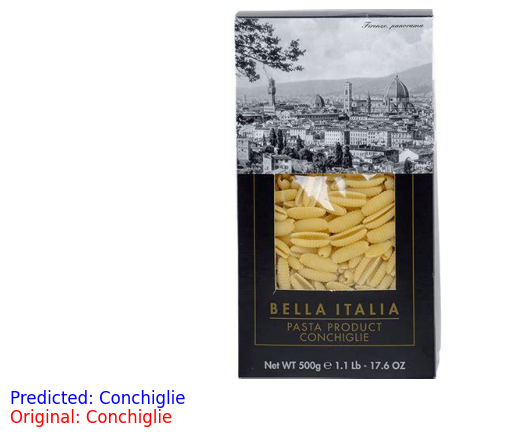

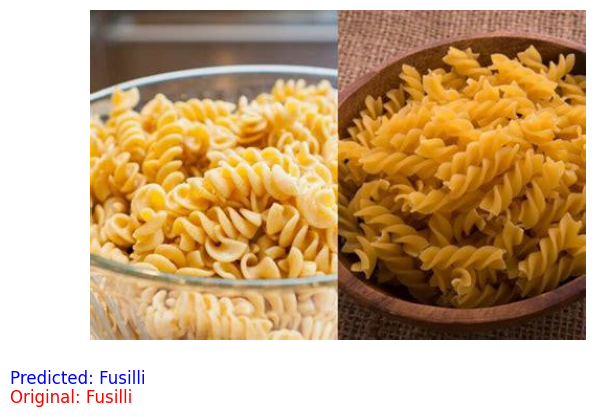

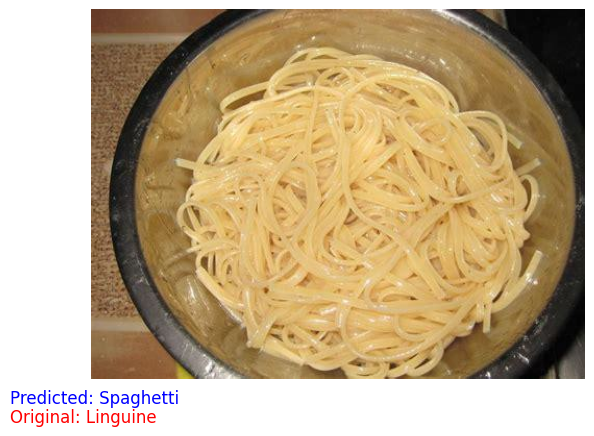

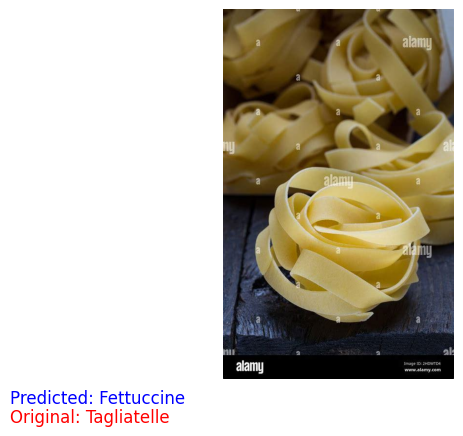

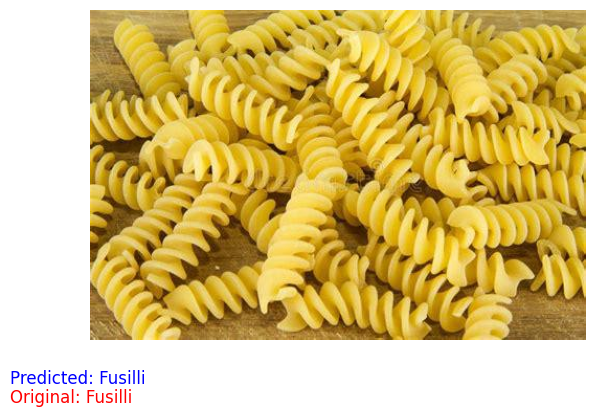

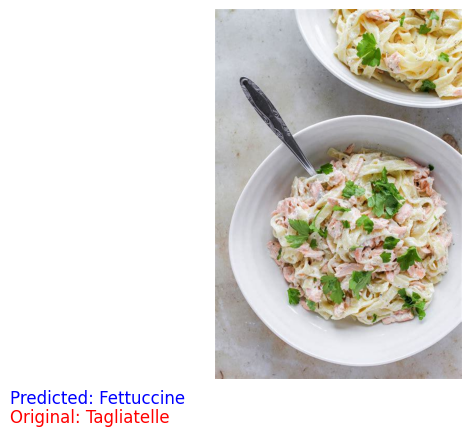

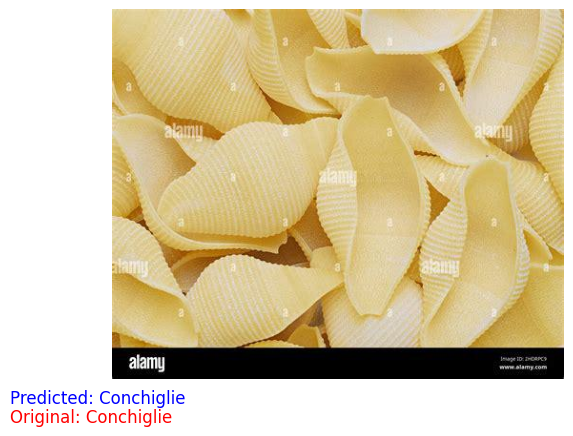

In [75]:
model = create_model(model_name, num_classes)
model.to(device)

model.load_state_dict(checkpoint["model"])
model.eval()
test_transform = create_test_transforms()[0]

for _ in range(10):
    sample_i = torch.randint(0, len(test_data), (1,)).item()

    image_path = test_data[sample_i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = CLASS_DECODER[test_label[sample_i]]

    image_tensor = test_transform(image=image)["image"]

    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        pred = model(image_tensor)
        pred = torch.argmax(pred, dim=-1)
        pred = CLASS_DECODER[pred.item()]

    plt.imshow(image)
    plt.axis('off')
    plt.gcf().text(0.0, 0.06, f'Predicted: {pred}', ha='left', fontsize=12, color='blue')
    plt.gcf().text(0.0, 0.02, f'Original: {target}', ha='left', fontsize=12, color='red')
    plt.show()






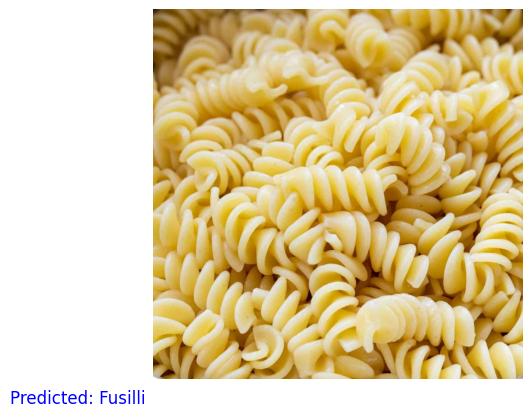

In [79]:
sample_image_dir = os.path.join(GOOGLE_DRIVE_PATH, "sample_images")
image_path = sample_image_dir + "/pasta3.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
target = CLASS_DECODER[test_label[sample_i]]

image_tensor = test_transform(image=image)["image"]

with torch.no_grad():
    image_tensor = image_tensor.unsqueeze(0).to(device)
    pred = model(image_tensor)
    pred = torch.argmax(pred, dim=-1)
    pred = CLASS_DECODER[pred.item()]

plt.imshow(image)
plt.axis('off')
plt.gcf().text(0.0, 0.06, f'Predicted: {pred}', ha='left', fontsize=12, color='blue')
plt.show()

In [80]:
!git pull
!git config --global user.email "tomhyhan@gmail.com"
!git config --global user.name username
!git add .
!git status
!git commit -m "updated trainer"
!git push https://{token}@github.com/{username}/{repo_name}.git

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   model/data.py
	modified:   model/viz.py

[main e6aa35e] updated trainer
 2 files changed, 5 insertions(+)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 497 bytes | 497.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/tomhyhan/noodles.git
   d74df89..e6aa35e  main -> main
